# Import data from yahoo

In [1]:
from pandas_datareader import data
%matplotlib inline  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys,traceback
import h5py

In [2]:
# Define which online source one should use
data_source = 'yahoo'

# We would like all available data from 2000-6-23 until 2017-7-23. the event date is 2017-6-23
start_date = '2000-6-23'
end_date = '2017-7-23'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
ts = (data.DataReader('^FTSE', data_source, start_date, end_date)['Adj Close']).dropna()
#event = data.DataReader('ORCL', data_source, '2017-1-13', '2017-11-23')['Adj Close'][:150]

# Define methods for ploting and summarizing the gain

In [3]:
def plotData(data,x_label,y_label,title,ylim=None):
    plt.rcParams["figure.figsize"] = [15.0,10.0]
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend('price legend')
    if ylim:
        plt.ylim(ylim[0],ylim[1])
    data.plot()

In [4]:
#plotData(panel_data,'Date','Price','Plot data')

In [5]:
def gainPercentage(ts):
    ts_gain = pd.DataFrame(columns=['gain'])
    data = ts[1:]
    previous_index = ts.index[0]
    for index_ts, row_ts in data.iteritems():
        gain_value = (ts[index_ts] - ts[previous_index])/ts[previous_index]
        ts_gain.loc[index_ts] = gain_value
        previous_index = index_ts
    return ts_gain.gain


In [6]:
def dropOutliers(train_data,sd_coef):
    data_gain = gainPercentage(train_data)
    mean_gain = np.mean(data_gain.values)
    risk = np.std(data_gain.values)
    
    for gain,index in zip(data_gain.values,data_gain.index):
        if gain > mean_gain + (risk*sd_coef) or gain < mean_gain - (risk*sd_coef):
            if data_gain[0] == gain:
                data_gain[0] = data_gain[1]
            else :
                if data_gain[-1] == gain:
                    data_gain[-1] = data_gain[-2]
                else:
                    prev_val = data_gain.shift(1)[data_gain.index.get_loc(index)]
                    next_val = data_gain.shift(-1)[data_gain.index.get_loc(index)]
                    data_gain[data_gain.index.get_loc(index)] = (prev_val + next_val ) / 2
        
    return data_gain
            
    

# Plot gain with and without outliers

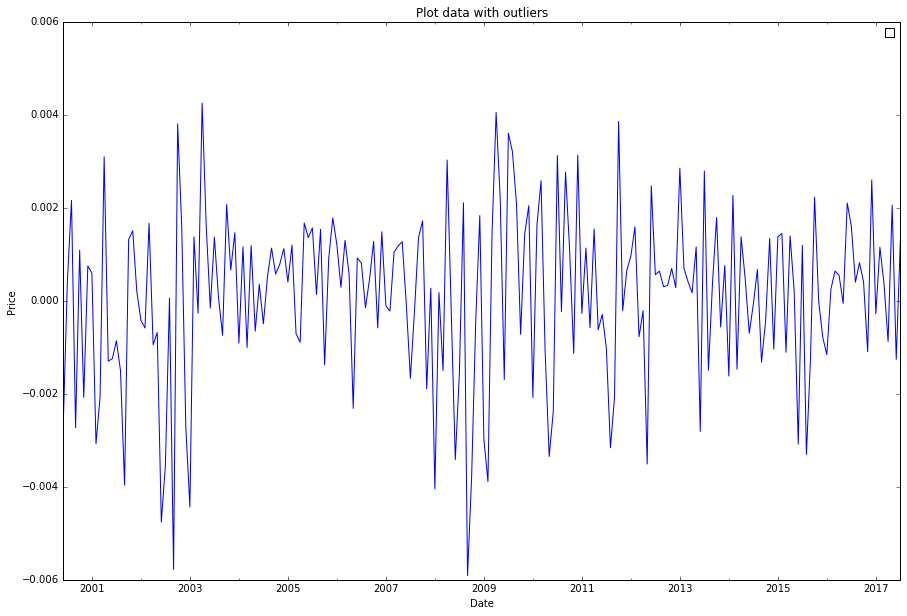

In [10]:
plotData(gainPercentage(ts).resample('M').mean(),'Date','Price','Plot data with outliers')

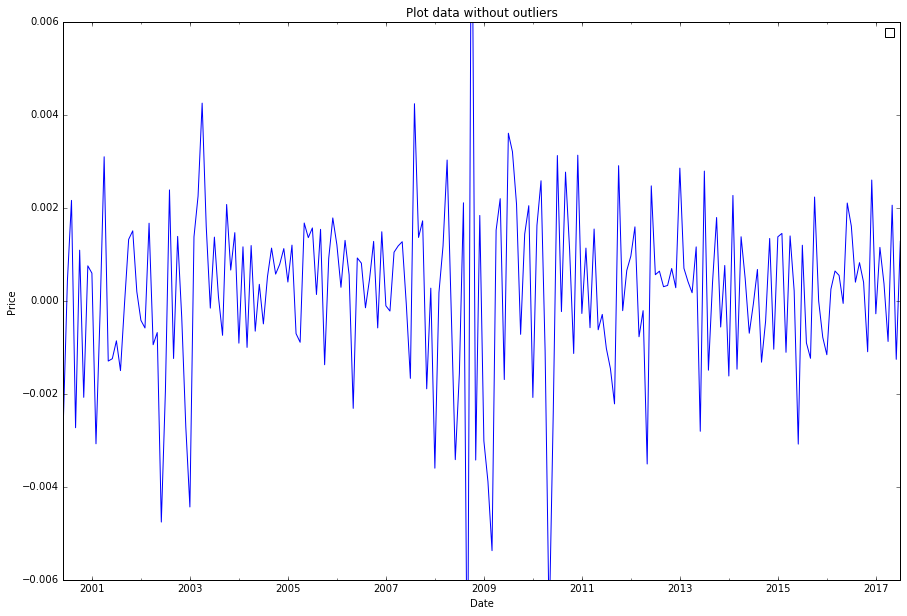

In [12]:
plotData(dropOutliers(ts,3).resample('M').mean(),'Date','Price','Plot data without outliers',ylim=[-0.006,0.006])

# Build Arema Model

In [99]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

In [ ]:
def trainTimeSeries(train_data,validation_data,p_values,d_values,q_values):
    
    configs = {}
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    arima_order = (p,d,q)
                    history = train_data.values.tolist()
                    dates = train_data.index.tolist()
                    predictions = list()
                    exo = (train_data.index.weekday+1).tolist()
                    for value,index in zip(validation_data.values,validation_data.index):
                        model = ARIMA(history, order=arima_order,dates=dates)
                        model_fit = model.fit(disp=0)
                        yhat = model_fit.forecast()[0]
                        predictions.append(yhat)
                        history.append(value)
                        dates.append(index)
                        exo.append(index.weekday()+1)
                    error = mean_squared_error(validation_data.values, predictions)
                    configs[arima_order]=error
                    print(arima_order," ---> ",error)
                except:
                    print ("Unexpected error:", sys.exc_info()[0])
                    traceback.print_exc(file=sys.stdout)
                    continue
    
    best_config = min(zip(list(configs.values()), list(configs.keys())))
    print("best config  : ",best_config)
    fit_data = train_data.append(validation_data)
    model = ARIMA(fit_data.values.tolist(), order=best_config[1],dates=fit_data.index.tolist()).fit(disp=0)
    #return ARIMA(fit_data.values.tolist(), order=best_config,dates=fit_data.index.tolist()).fit(disp=0,method='css'),
    return  best_config


In [ ]:
def predictSerie(data,arima_order,predicted_dates):

    history = data.values.tolist()
    dates = data.index.tolist()
    predictions = list()
    for index in predicted_dates:
        model = ARIMA(history, order=arima_order,dates=dates)
        model_fit = model.fit(disp=0,method='css')
        yhat = model_fit.forecast(exog=exo[-1:])[0]
        predictions.append(yhat)
        history.append(yhat)
        dates.append(index)
    
    return pd.Series(data=predictions,index=predicted_dates)
      

In [ ]:
#gain_ts = gainPercentage(ts)
gain_ts = ts
train_data = gain_ts['2012-05-23':'2013-05-23']
validation_data = gain_ts['2013-05-23':'2014-05-23']
p_values = range(0,8)
d_values = range(2)
q_values = range(2)

warnings.filterwarnings("ignore")
best_order = trainTimeSeries(train_data,validation_data,p_values,d_values,q_values)

predictions = predictSerie(gain_ts['2012-05-23':'2014-05-23'],best_order,gain_ts['2014-05-23':].index.tolist())
predictions

In [ ]:
plt.plot(gain_ts['2014-05-23':].index,gain_ts['2014-05-23':].values,predictions.index,predictions.values)
plt.rcParams["figure.figsize"] = [15.0,10.0]
#plt.ylim(-0.1,0.1)
plt.show()

# LSTM WITH ONE OUTPUT

In [12]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# convert an array of values into a dataset matrix
# dataset is created using sliding windows with a size of 1
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset before the event
dataset = ts[:'2017-6-23'].values.reshape(-1,1)
dataset = dataset.astype('float32')
# normalize the dataset
#here we're using MinMax scaller , we can use standard scaller too
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

(2992, 1)
Epoch 1/5
 - 13s - loss: 0.0062
Epoch 2/5
 - 11s - loss: 1.7062e-04
Epoch 3/5
 - 12s - loss: 1.6158e-04
Epoch 4/5
 - 11s - loss: 1.5984e-04
Epoch 5/5
 - 12s - loss: 1.5434e-04


In [13]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
'''first = testX[0].reshape(1,1,1)
testPredict = list()
for i in range(150):
    testPredict.append(model.predict(first))
    first = model.predict(first).reshape(1,1,1)
testPredict = [x[0] for x in testPredict]'''

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
# fill an array that has the dataset size, but only fill the training part and give zeroes to other
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
#same shifting but for test data
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


Train Score: 0.54 RMSE
Test Score: 1.09 RMSE


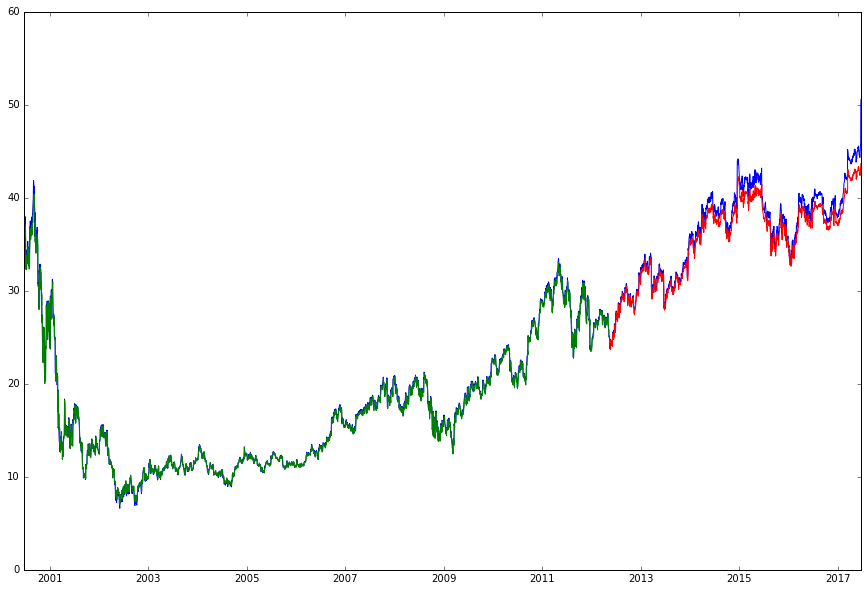

In [36]:
# plot baseline and predictions
plt.plot(ts[:'2017-6-23'].index,scaler.inverse_transform(dataset))
plt.plot(ts[:'2017-6-23'].index,trainPredictPlot)
plt.plot(ts[:'2017-6-23'].index,testPredictPlot)
plt.rcParams["figure.figsize"] = [15.0,10.0]
#plt.axis(['2016-5-23','2016-7-23',6000,6500])
plt.show()

# LSTM WITH multiple OUTPUT

In [228]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.layers import LSTM, GRU
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_squared_log_error

# convert an array of values into a dataset matrix
# dataset is created using sliding windows with a size of 1
def create_dataset(dataset, look_back=1,output_size=10,window_size=1):
    dataX, dataY = [], []
    for i in np.arange(0,len(dataset)-look_back-1-output_size, window_size): 
    #for i in range(len(dataset)-look_back-1-output_size):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back:i + look_back+output_size, 0])
    return numpy.array(dataX), numpy.array(dataY)



In [150]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset before the event
dataset = ts[:'2017-6-23'].values.reshape(-1,1)
dataset = dataset.astype('float32')
# normalize the dataset
#here we're using MinMax scaller , we can use standard scaller too
#scaler = StandardScaler(with_std=False)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

array([[ 0.73388714],
       [ 0.72865325],
       [ 0.7318688 ],
       ..., 
       [ 0.97657603],
       [ 0.97458094],
       [ 0.97101349]], dtype=float32)

In [255]:
# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
# look back is fixed to 300 => 13 months
look_back = 60
#size of Y samples
output_size=10
window_size = 1
trainX, trainY = create_dataset(train, look_back,window_size=window_size)
testX, testY = create_dataset(test, look_back,window_size=window_size)
#print(trainX[:2])
print(trainY.shape)

(3366, 10)


In [256]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (-1, look_back, 1))
testX = numpy.reshape(testX, (-1, look_back, 1))

trainY = numpy.reshape(trainY, (-1, output_size))
testY = numpy.reshape(testY, (-1, output_size))
print(testY.shape)

(789, 10)


In [220]:
# create and fit the LSTM network
# The first layer has 30 units on each cell , the number of cells is the input size which is in ou case the look_back
# the return sequence specifies if all the cells should return values of only the last cell (return_sequence=False)
# In case return_sequence is true we will return an array with the look_back size , each value of the array is also an array with 30 values
# each value on the first array represent the output of a cell , and each cell return 30 values because it has 30 units in it
# the last layer must have a return_sequence = False in order to return only the last cell's output (in our case 30 values)
# Dense represent a simple layer in a neural network, with means that the last cell (on the last layer of LSTMs) is fully connectes to a neural network layer
# the last Dense layer must have the same size as the real output (in out case we predict 10 values se Dense has 10 units)
model = Sequential()
model.add(LSTM(80, input_shape=(look_back, 1),return_sequences=False))
'''model.add(LSTM(40,return_sequences=True))
model.add(LSTM(30,return_sequences=True))
model.add(LSTM(30,return_sequences=False))
model.add(Dense(30))
model.add(Dropout(0.4))
model.add(Activation('tanh'))
model.add(Dense(20))
model.add(Dropout(0.4))
model.add(Dense(10))'''
model.add(Dense(10))
model.add(Activation('sigmoid'))

model.compile(loss='mean_squared_logarithmic_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=5, verbose=2)

Epoch 1/100
 - 70s - loss: 0.0033
Epoch 2/100
 - 48s - loss: 0.0010
Epoch 3/100
 - 48s - loss: 8.2127e-04
Epoch 4/100
 - 48s - loss: 7.1538e-04
Epoch 5/100
 - 48s - loss: 6.7108e-04
Epoch 6/100
 - 48s - loss: 6.2195e-04
Epoch 7/100
 - 48s - loss: 6.1356e-04
Epoch 8/100
 - 48s - loss: 5.8770e-04
Epoch 9/100
 - 48s - loss: 5.7565e-04
Epoch 10/100
 - 49s - loss: 5.5474e-04
Epoch 11/100
 - 50s - loss: 5.4062e-04
Epoch 12/100
 - 50s - loss: 5.5572e-04
Epoch 13/100
 - 50s - loss: 5.3717e-04
Epoch 14/100
 - 50s - loss: 5.2546e-04
Epoch 15/100
 - 50s - loss: 5.2567e-04
Epoch 16/100
 - 50s - loss: 5.1501e-04
Epoch 17/100
 - 52s - loss: 5.1163e-04
Epoch 18/100
 - 50s - loss: 5.1009e-04
Epoch 19/100
 - 50s - loss: 5.0365e-04
Epoch 20/100
 - 50s - loss: 5.0710e-04
Epoch 21/100
 - 50s - loss: 5.0582e-04
Epoch 22/100
 - 50s - loss: 5.0823e-04
Epoch 23/100
 - 50s - loss: 4.9549e-04
Epoch 24/100
 - 50s - loss: 4.9451e-04
Epoch 25/100
 - 53s - loss: 4.9704e-04
Epoch 26/100
 - 53s - loss: 4.9785e-04
Epo

In [221]:
#save the model into a h5 format (an hdfs format), pickle is not compatible with keras objects
import h5py
name = "h5-models/FTSE_model_with_loss_3-9847e-04-batch-5.h5"
model.save(name)

In [257]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [258]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_log_error(trainY,trainPredict))
print('Train Score: %.2f RMLSE' % (trainScore))
testScore = math.sqrt(mean_squared_log_error(testY, testPredict))
print('Test Score: %.2f RMLSE' % (testScore))

Train Score: 0.02 RMLSE
Test Score: 0.03 RMLSE


### plot 10 days

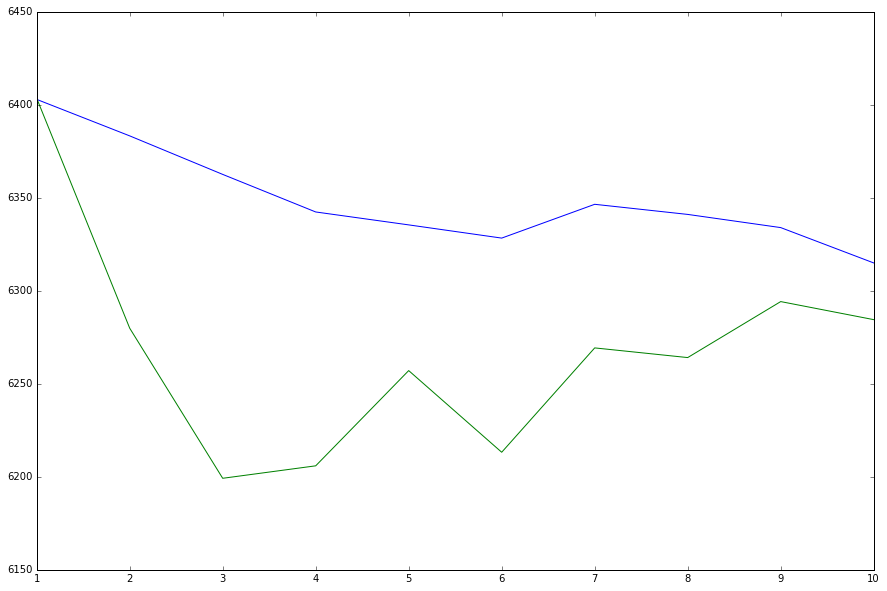

 Correlation between predicted values and real values for 1 month is :  [[ 1.          0.49094702]
 [ 0.49094702  1.        ]]


In [235]:
index = 1

plt.plot(range(1,11),testPredict[index])
plt.plot(range(1,11),testY[index])
plt.rcParams["figure.figsize"] = [15.0,10.0]
#plt.axis(['2016-5-23','2016-7-23',6000,6500])
plt.show()

print(" Correlation between predicted values and real values for 1 month is : ",np.corrcoef(scaler.inverse_transform(result[0].reshape(1, -1))[0],scaler.inverse_transform(testY[index].reshape(1, -1))[0]))

# Plot train Set

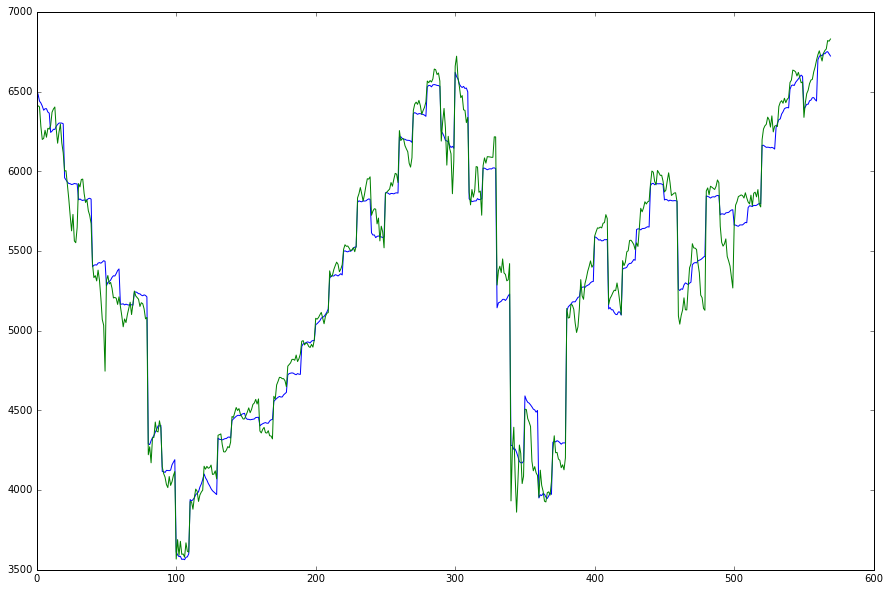

In [261]:
predicted_train_windows = list()
train_windows = list()

for i in np.arange(0,len(trainPredict),look_back):
    predicted_train_windows.append(trainPredict[i])
    train_windows.append(trainY[i])

predicted_train_windows = numpy.asarray(predicted_train_windows).flatten()
train_windows = numpy.asarray(train_windows).flatten()
plt.plot(predicted_train_windows)
plt.plot(train_windows)
plt.rcParams["figure.figsize"] = [15.0,10.0]
#plt.axis(['2016-5-23','2016-7-23',6000,6500])
plt.show()

# plot Test Set

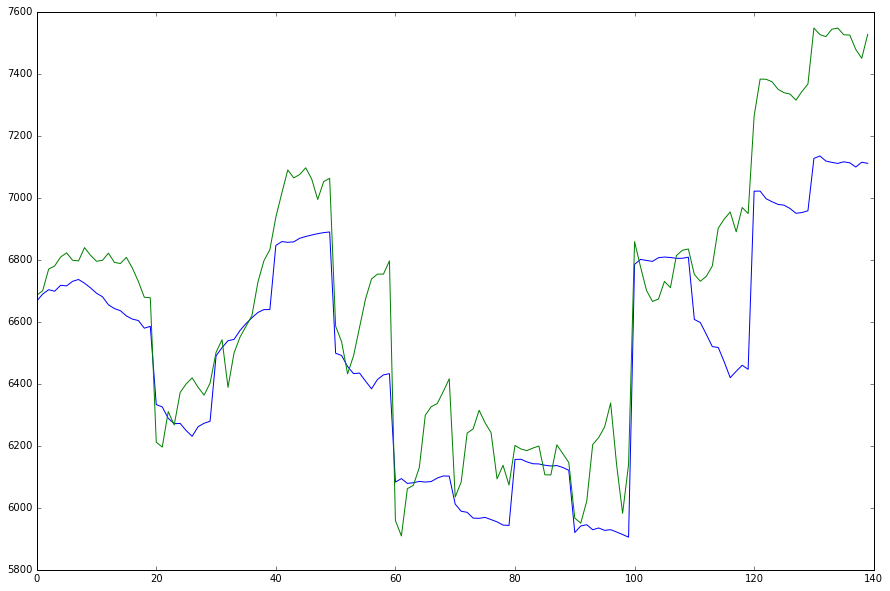

In [260]:
predicted_windows = list()
test_windows = list()

for i in np.arange(0,len(testPredict),look_back):
    predicted_windows.append(testPredict[i])
    test_windows.append(testY[i])

predicted_windows = numpy.asarray(predicted_windows).flatten()
test_windows = numpy.asarray(test_windows).flatten()
plt.plot(predicted_windows)
plt.plot(test_windows)
plt.rcParams["figure.figsize"] = [15.0,10.0]
#plt.axis(['2016-5-23','2016-7-23',6000,6500])
plt.show()